# GAN Architecture with Attention -- Tensorflow implementation

PENDING
- which losses for intermediary (approx) network?
- size of filter is weird

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle
import os
from pathlib import Path
import tensorflow as tf

from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.optimizers import Adam

In [307]:
cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_masks.pickle')
cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_original.pickle')
cars_filter_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_filter.pickle')

#cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/faces_masks.pickle')
#cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/faces_original.pickle')
#cars_filter_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/faces_filter.pickle')

In [308]:
with open(cars_mask_path, 'rb') as file:
    X_mask = pickle.load(file)
    
print(X_mask.shape)

(16185, 3, 64, 64)


In [309]:
with open(cars_original_path, 'rb') as file:
    X_original = pickle.load(file)
    
print(X_original.shape)

(16185, 3, 64, 64)


In [310]:
with open(cars_filter_path, 'rb') as file:
    X_filter = pickle.load(file)
    
print(X_filter.shape)

(8144, 64, 64, 3)


In [607]:
def load_data(X_original_, X_mask_, X_filter_, n_inf, n_sup):
    X_image, X_mask, X_filt = X_original_[n_inf:n_sup], X_mask_[n_inf:n_sup], X_filter_[n_inf:n_sup]
    X_image = X_image.transpose((0, 2, 3, 1))
    X_mask = X_mask.transpose((0, 2, 3, 1))
    #X_image = X_image[:, :, :, 0]
    #X_mask = X_mask[:, :, :, 0]
    #X_image = X_image.reshape(X_image.shape[0], -1)
    #X_mask = X_mask.reshape(X_mask.shape[0], -1)
    return (X_image, X_mask, X_filt)


print("Training Set")
X_train, X_train_mask, X_train_filter = load_data(X_original, X_mask, X_filter, 0, 1)
print('  image', X_train.shape)
print('  masked image', X_train_mask.shape)
print('  mask filter', X_train_filter.shape)

print("Testing Set")
X_test, X_test_mask, X_test_filter = load_data(X_original, X_mask, X_filter, 1000, 1100)
print('  image', X_test.shape)
print('  masked image', X_test_mask.shape)
print('  mask filter', X_test_filter.shape)

Training Set
  image (1, 64, 64, 3)
  masked image (1, 64, 64, 3)
  mask filter (1, 64, 64, 3)
Testing Set
  image (100, 64, 64, 3)
  masked image (100, 64, 64, 3)
  mask filter (100, 64, 64, 3)


In [ ]:
# Concat image and filter mask for other nets architecture
def load_data_concat(X_image, X_mask, X_filt):
    X_concat = np.concatenate([X_image, X_filt], axis=0)
    return X_concat, X_mask

X_train, X_train_mask = load_data_concat(X_train, X_train_mask, X_train_filter)
X_test, X_test_mask = load_data_concat(X_test, X_test_mask, X_test_filter)


print("Training Set")
print('  image + filter', X_train.shape)
print('  masked image', X_train_mask.shape)

print("Testing Set")
print('  image + filter', X_test.shape)
print('  masked image', X_test_mask.shape)

# GAN Model

In [84]:
image_size = (64, 64, 3)
n_pixels = int(image_size[0]*image_size[1]*image_size[2])

epochs = 20
batch_size = 128

In [85]:
tf.reset_default_graph()

with tf.variable_scope("approx_net"):
    # user inputs
    masked_image_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    mask_filter_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    real_image_targets = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    # reshaping as a long vector (for Dense Net ...)
    masked_image_inputs_r = tf.reshape(masked_image_inputs, shape=(-1,n_pixels))
    
    # First reconstruction net to grossly approximate the masked region
    images = tf.layers.dense(masked_image_inputs_r, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=100) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    reconstructed_images = tf.layers.dense(images, units=n_pixels, activation=tf.nn.sigmoid)
    
    # reshaping as a image format again (for Dense Net ...)
    reconstructed_images = tf.reshape(reconstructed_images, shape=(-1,)+image_size)
    
    
with tf.variable_scope("attention_generator"):
    
    gamma = tf.get_variable("gamma", shape=[1], initializer=tf.constant_initializer(0.0))
    
    attention_input = tf.multiply(mask_filter_inputs, reconstructed_images) \
                    + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
    #attention_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    attention_input_c = tf.layers.conv2d(attention_input, filters=64, kernel_size=3, strides=2, padding="same")
    attention_input_c = tf.layers.conv2d(attention_input_c, filters=64, kernel_size=3, strides=2, padding="same")
    
    f_branch = tf.layers.conv2d(attention_input, filters=32, kernel_size=1, padding="same")
    g_branch = tf.layers.conv2d(attention_input, filters=32, kernel_size=1, padding="same")
    d_ = f_branch.shape[1]

    f_branch = tf.reshape(f_branch, shape=(-1, f_branch.shape[1]*f_branch.shape[2], f_branch.shape[3]))
    g_branch = tf.reshape(g_branch, shape=(-1, g_branch.shape[1]*g_branch.shape[2], g_branch.shape[3]))
    
    h_branch = tf.layers.conv2d(attention_input_c, filters=64, kernel_size=1, padding="same")
    h_branch = tf.reshape(h_branch, shape=(-1, h_branch.shape[1]*h_branch.shape[2], h_branch.shape[3]))
    
    #attention_map = tf.expand_dims(tf.nn.softmax(tf.reduce_sum(tf.multiply(f_branch, g_branch), axis=3)), 3)
    attention_map = tf.matmul(f_branch, g_branch, transpose_b=True)
    
    attention_output = tf.matmul(attention_map, h_branch)
    attention_output = tf.reshape(attention_output, shape=(-1, d_ ,d_ ,attention_output.shape[2]))
    
    output_images = tf.layers.conv2d_transpose(attention_output, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    output_images = tf.layers.conv2d_transpose(output_images, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    output_images = tf.multiply(mask_filter_inputs, output_images) \
                        + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  

with tf.variable_scope("discriminator"):
    
    # Labels fake/real
    true_labels = tf.placeholder(tf.float32, shape=[None,2])
    #discriminator_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    discriminator_input = output_images
    
    #if training_generator:
    #    x = output_images
    #else:
    #    x = discriminator_input
        
    x = tf.layers.conv2d(discriminator_input, filters=16, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, units=50, activation=tf.nn.relu)
    class_logits = tf.layers.dense(x, units=2)
    
    
with tf.variable_scope('losses'):
    # Loss is L2 error on the masked region only
    #loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.))
    #L1_loss = tf.reduce_mean(tf.losses.absolute_difference(real_image_targets, reconstructed_images,
    #                                                       scope=mask_filter_inputs==1.))
    
    reco_loss1 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - reconstructed_images)*mask_filter_inputs))
    #reco_loss1 = tf.losses.absolute_difference(real_image_targets*mask_filter_inputs,reconstructed_images*mask_filter_inputs)
    reco_loss2 = tf.reduce_mean(tf.nn.l2_loss(real_image_targets - output_images))
    #reco_loss2 = tf.losses.absolute_difference(real_image_targets, output_images)
    
    #perception_loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.)) \
    #                  -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, output_images, max_val=1.))
    
    # will be fed with both fake/real images only
    d_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="d_loss"))
    #d_loss = tf.reduce_mean(true_labels * tf.log(classify) + (1-true_labels)*tf.log(1-classify)) + 0.1*L1_loss
    # will be fed with both fake/real images only
    g_loss_gan = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="g_loss"))
    g_loss_reco = reco_loss2 + reco_loss1
    #g_loss = 0*g_loss_gan + 1*g_loss_reco
    g_loss = g_loss_reco
    
with tf.variable_scope('Optimizer'):
    
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # G Training
    vars_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "approx_net") + \
             tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "attention_generator")
    train_op_g = optimizer_g.minimize(g_loss, var_list=vars_g)
    
    # D Training
    vars_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
    train_op_d = optimizer_d.minimize(d_loss, var_list=vars_d)


In [86]:
# /!\/!\/!\/!\/!\
sess_gan = tf.Session()
    
sess_gan.run(tf.global_variables_initializer())
# /!\/!\/!\/!\/!\

history = {'loss_g':[], 'loss_d':[], 'loss_perception':[]}

In [93]:
for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        """
        # boolean, True if we are training G
        #training_generator = False
        
        # load batch_size fake images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        fake_images_mask = X_train_mask[idx]
        fake_images_filter = X_train_filter[idx]
        feed_dict = {masked_image_inputs: fake_images_mask,
                     mask_filter_inputs: fake_images_filter}
        fake_images = sess_gan.run(output_images, feed_dict=feed_dict)
        
        # load batch_size real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        real_images_mask = X_train_mask[idx]
        real_images_filter = X_train_filter[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        input_masks = np.concatenate([real_images_mask, fake_images_mask])
        input_filters = np.concatenate([real_images_filter, fake_images_filter])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input: input_images,
                     mask_filter_inputs: input_filters,
                     real_image_targets: input_images,
                     true_labels: labels}
        _, train_loss_d = sess_gan.run([train_op_d, d_loss], feed_dict=feed_dict)
        """
        #training_generator = True
        
        # Freeze D and train Generator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        labels = np.zeros((batch_size, 2))
        labels[:, 1] = 1.
        feed_dict = {discriminator_input: X_train_mask[idx], # not matter what
                     masked_image_inputs: X_train_mask[idx],
                     mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx],
                     true_labels: labels}
        _, train_loss_g = sess_gan.run([train_op_g, g_loss], feed_dict=feed_dict)
        
        history['loss_g'].append(train_loss_g)
        history['loss_d'].append(train_loss_d)
        
    if epoch % 1 == 0:
        feed_dict = {masked_image_inputs: X_test_mask,
                     mask_filter_inputs: X_test_filter,
                     real_image_targets: X_test}
        test_perception_loss = sess_gan.run(g_loss, feed_dict=feed_dict)
        print("Step {0}/{1} \ttrain D loss: {2} \ttrain G loss {3}"\
              .format(epoch, epochs, train_loss_d, train_loss_g, test_perception_loss))
        history['loss_perception'].append(test_perception_loss)

Step 0/20 	train D loss: 0.43418630957603455 	train G loss 5743.212890625
Step 1/20 	train D loss: 0.43418630957603455 	train G loss 5375.4462890625
Step 2/20 	train D loss: 0.43418630957603455 	train G loss 5619.8251953125
Step 3/20 	train D loss: 0.43418630957603455 	train G loss 5597.021484375
Step 4/20 	train D loss: 0.43418630957603455 	train G loss 5334.2822265625
Step 5/20 	train D loss: 0.43418630957603455 	train G loss 5549.236328125
Step 6/20 	train D loss: 0.43418630957603455 	train G loss 5425.689453125
Step 7/20 	train D loss: 0.43418630957603455 	train G loss 5626.39013671875
Step 8/20 	train D loss: 0.43418630957603455 	train G loss 5296.7509765625
Step 9/20 	train D loss: 0.43418630957603455 	train G loss 5887.0537109375
Step 10/20 	train D loss: 0.43418630957603455 	train G loss 4997.158203125
Step 11/20 	train D loss: 0.43418630957603455 	train G loss 5580.837890625
Step 12/20 	train D loss: 0.43418630957603455 	train G loss 5664.74560546875
Step 13/20 	train D loss: 

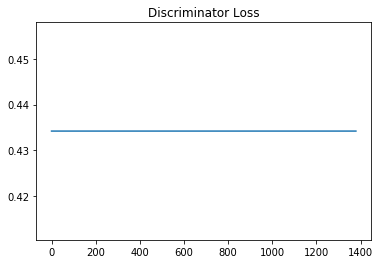

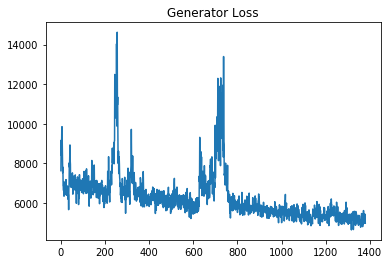

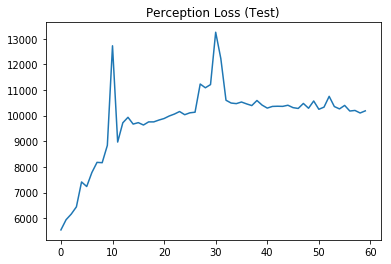

In [94]:
plt.plot(history['loss_d'])
plt.title("Discriminator Loss")
plt.show()

plt.plot(history['loss_g'])
plt.title("Generator Loss")
plt.show()

plt.plot(history['loss_perception'])
plt.title("Perception Loss (Test)")
plt.show()

In [72]:
"""def display_attention(mask, att_map):
    mask_flat = mask[:, :, 0].reshape((1, -1))
    print(mask_flat.shape)
    att_map = att_map[mask_flat]
    prob_sum = sum(att_map, axis=0)
    return prob_sum.reshape(mask.shape)

display_attention(X_test_mask[1], att_map[1])"""

'def display_attention(mask, att_map):\n    mask_flat = mask[:, :, 0].reshape((1, -1))\n    print(mask_flat.shape)\n    att_map = att_map[mask_flat]\n    prob_sum = sum(att_map, axis=0)\n    return prob_sum.reshape(mask.shape)\n\ndisplay_attention(X_test_mask[1], att_map[1])'

In [29]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, att_out, out_imgs = sess_gan.run([reconstructed_images, 
                                             attention_map,
                                             attention_output,
                                             output_images], 
                                             feed_dict=feed_dict)

i = 61

print(att_out[i].shape)

(16, 16, 128)


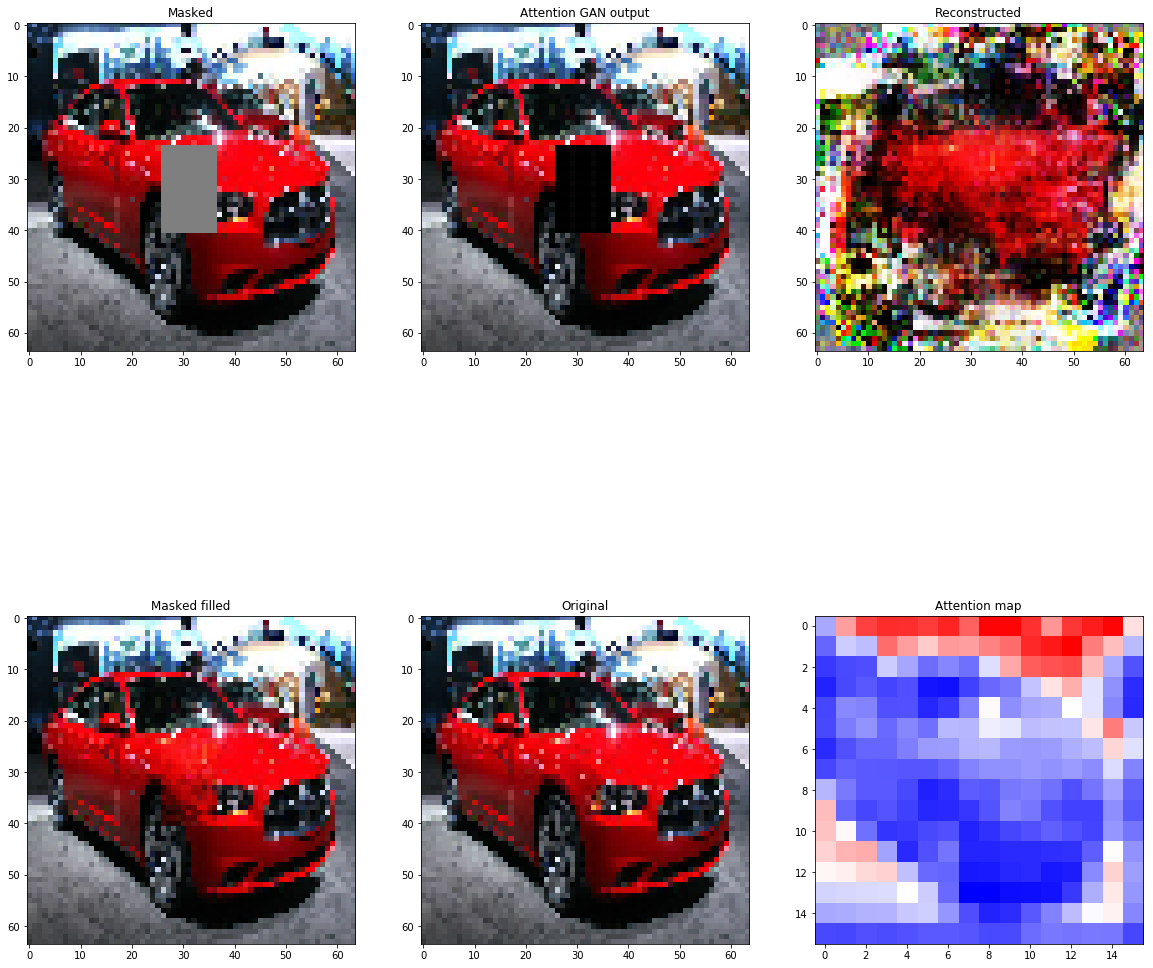

In [95]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, out_imgs = sess_gan.run([reconstructed_images, attention_map, output_images], 
                                             feed_dict=feed_dict)

i = 61
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.subplot(2, 3, 4)
plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Masked filled")
plt.subplot(2, 3, 2)
plt.imshow(out_imgs[i])
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i][8].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_test[i])
plt.title("Original")

plt.show()

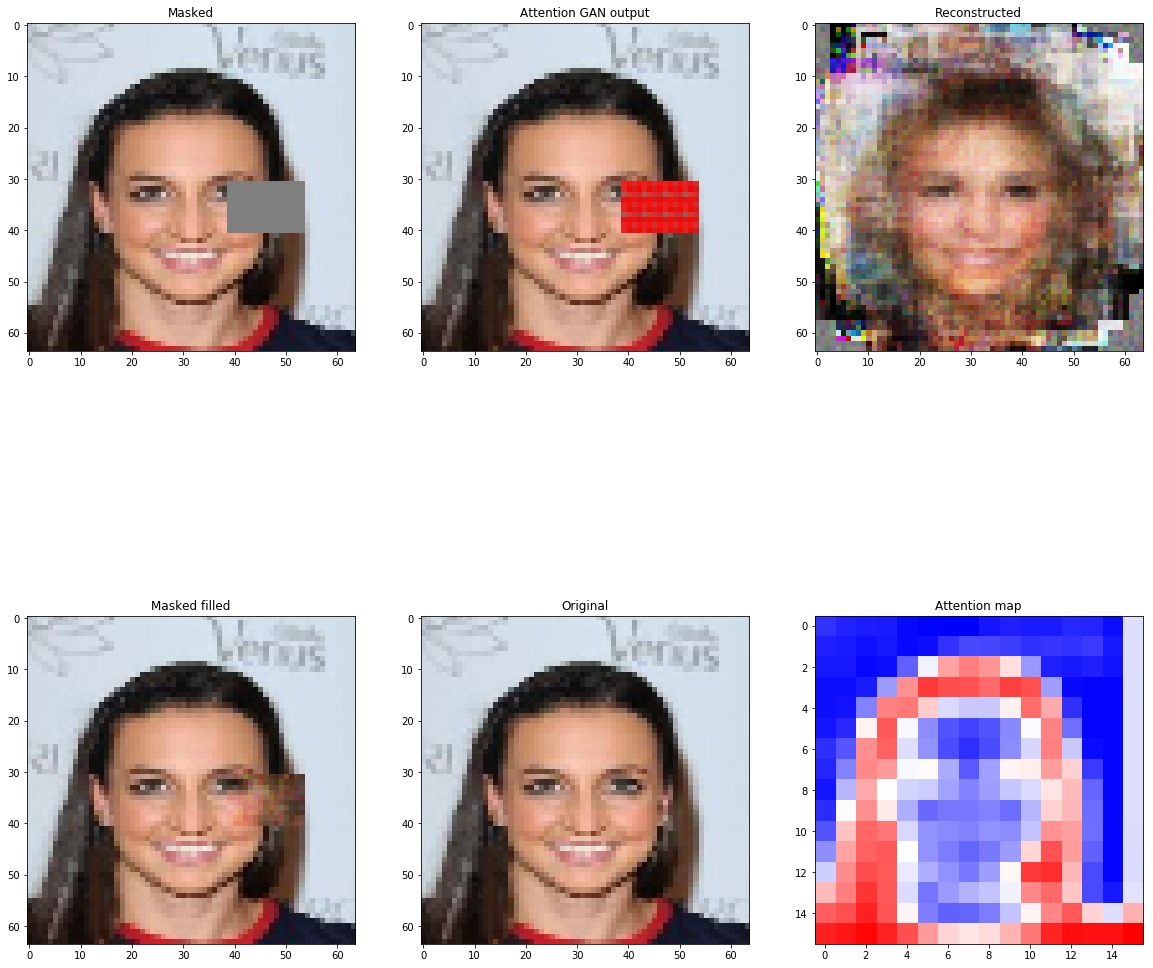

In [56]:
# /!\ TRAIN SET /!\

feed_dict = {masked_image_inputs: X_train_mask,
             mask_filter_inputs: X_train_filter,
             real_image_targets: X_train}

reco_imgs, att_map, out_imgs = sess_gan.run([reconstructed_images, attention_map, output_images], 
                                             feed_dict=feed_dict)

i = 2
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_train_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.subplot(2, 3, 4)
plt.imshow(X_train_filter[i]*reco_imgs[i] + (1-X_train_filter[i])*X_train_mask[i])
plt.title("Masked filled")
plt.subplot(2, 3, 2)
plt.imshow(out_imgs[i])
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i][8].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_train[i])
plt.title("Original")

plt.show()

### TensorBoard

In [45]:
logdir = 'tensorboard/'

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [46]:
#/!\ Interrupt kernel to stop 

!tensorboard --logdir=$logdir

TensorBoard 1.11.0 at http://MacBook-Air-de-Clement.local:6006 (Press CTRL+C to quit)
^C


# GAN (Attention debug)

In [671]:
image_size = (64, 64, 3)
n_pixels = int(image_size[0]*image_size[1]*image_size[2])

epochs = 5
batch_size = 1

In [674]:
tf.reset_default_graph()

with tf.variable_scope("approx_net"):
    # user inputs
    masked_image_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    mask_filter_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    real_image_targets = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    # reshaping as a long vector (for Dense Net ...)
    masked_image_inputs_r = tf.reshape(masked_image_inputs, shape=(-1,n_pixels))
    
    # First reconstruction net to grossly approximate the masked region
    #images = tf.layers.dense(masked_image_inputs_r, units=512) 
    #images = tf.nn.leaky_relu(images, alpha=0.2)
    
    #images = tf.layers.dense(images, units=100) 
    #images = tf.nn.leaky_relu(images, alpha=0.2)
    
    #images = tf.layers.dense(images, units=512) 
    #images = tf.nn.leaky_relu(images, alpha=0.2)
    
    #reconstructed_images = tf.layers.dense(images, units=n_pixels, activation=tf.nn.sigmoid)
    
    # reshaping as a image format again (for Dense Net ...)
    #reconstructed_images = tf.reshape(reconstructed_images, shape=(-1,)+image_size)
    
    
with tf.variable_scope("attention_generator"):
    
    
    #attention_input = tf.multiply(mask_filter_inputs, reconstructed_images) \
    #                + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
    attention_input = tf.placeholder(tf.float32, shape=(None,)+image_size)

    attention_input_c = tf.layers.conv2d(attention_input, filters=32, kernel_size=4, strides=1, padding="same", activation=tf.nn.relu)
    attention_input_c = tf.layers.conv2d(attention_input_c, filters=64, kernel_size=4, strides=1, padding="same", activation=tf.nn.relu)
    decode = tf.layers.conv2d_transpose(attention_input_c, filters=32, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
    decode = tf.layers.conv2d_transpose(decode, filters=3, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
    output_images = decode
    #attention_input_c = tf.nn.leaky_relu(tf.layers.batch_normalization(attention_input_c), 0.2)
    #attention_input_c = tf.layers.conv2d(attention_input_c, filters=64, kernel_size=3, strides=2, padding="same")
    #attention_input_c = tf.nn.leaky_relu(tf.layers.batch_normalization(attention_input_c), 0.2)
    
    d1 = attention_input_c
    
    #f_branch = tf.layers.conv2d(attention_input_c, filters=32, kernel_size=1, padding="same")
    #f_branch = tf.nn.leaky_relu(tf.layers.batch_normalization(f_branch), 0.2)
    #g_branch = tf.layers.conv2d(attention_input_c, filters=32, kernel_size=1, padding="same")
    #g_branch = tf.nn.leaky_relu(tf.layers.batch_normalization(g_branch), 0.2)
    #d_ = f_branch.shape[1]

    #f_branch = tf.reshape(f_branch, shape=(-1, f_branch.shape[1]*f_branch.shape[2], f_branch.shape[3]))
    #g_branch = tf.reshape(g_branch, shape=(-1, g_branch.shape[1]*g_branch.shape[2], g_branch.shape[3]))
    
    #h_branch = tf.layers.conv2d(attention_input_c, filters=64, kernel_size=1, padding="same")
    #h_branch = tf.nn.leaky_relu(tf.layers.batch_normalization(h_branch), 0.2)
    #h_branch = tf.reshape(h_branch, shape=(-1, h_branch.shape[1]*h_branch.shape[2], h_branch.shape[3]))
    
    #attention_map = tf.matmul(f_branch, g_branch, transpose_b=True)
    
    #attention_output = tf.matmul(attention_map, h_branch)
    #attention_output = tf.reshape(attention_output, shape=(-1, d_ ,d_ ,attention_output.shape[2]))
    
    #d2 = attention_output
    #attention_output = attention_input_c
    
    #output_images = tf.layers.conv2d_transpose(attention_output, filters=3, kernel_size=2, strides=2, padding="same")
    #output_images = tf.nn.leaky_relu(tf.layers.batch_normalization(output_images), 0.2)
    #output_images = tf.layers.conv2d_transpose(attention_output, filters=3, kernel_size=3, strides=1, padding="same")
    #output_images = tf.nn.leaky_relu(tf.layers.batch_normalization(output_images), 0.2)
    #output_images = tf.layers.conv2d_transpose(output_images, filters=3, kernel_size=3, strides=1, padding="same")
    #output_images = tf.nn.leaky_relu(tf.layers.batch_normalization(output_images), 0.2)
    #output_images = tf.layers.conv2d(output_images, filters=3, kernel_size=4, strides=1, padding="same")
    #output_images = tf.nn.sigmoid(output_images)
    #output_images = tf.layers.flatten(attention_output)
    #output_images = tf.layers.dense(output_images, units=n_pixels)
    #output_images = tf.reshape(output_images, shape=(-1,)+image_size)
    
    #output_images = tf.multiply(mask_filter_inputs, output_images) \
    #                    + tf.multiply(1-mask_filter_inputs, masked_image_inputs) 
    

with tf.variable_scope("discriminator"):
    
    # Labels fake/real
    true_labels = tf.placeholder(tf.float32, shape=[None,2])
    #discriminator_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    discriminator_input = output_images
    
    #if training_generator:
    #    x = output_images
    #else:
    #    x = discriminator_input
        
    x = tf.layers.conv2d(discriminator_input, filters=16, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, units=50, activation=tf.nn.relu)
    class_logits = tf.layers.dense(x, units=2)
    
    
with tf.variable_scope('losses'):
    # Loss is L2 error on the masked region only
    #loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.))
    #L1_loss = tf.reduce_mean(tf.losses.absolute_difference(real_image_targets, reconstructed_images,
    #                                                       scope=mask_filter_inputs==1.))
    
    #reco_loss1 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - reconstructed_images)*mask_filter_inputs))
    #reco_loss1 = tf.losses.absolute_difference(real_image_targets*mask_filter_inputs,reconstructed_images*mask_filter_inputs)
    #reco_loss2 = tf.reduce_mean(tf.nn.l2_loss(real_image_targets - output_images)) #/ tf.reduce_sum(mask_filter_inputs)
    reco_loss2 = tf.losses.absolute_difference(real_image_targets, output_images)
    
    #perception_loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.)) \
    #                  -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, output_images, max_val=1.))
    
    # will be fed with both fake/real images only
    d_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="d_loss"))
    #d_loss = tf.reduce_mean(true_labels * tf.log(classify) + (1-true_labels)*tf.log(1-classify)) + 0.1*L1_loss
    # will be fed with both fake/real images only
    g_loss_gan = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="g_loss"))
    g_loss_reco = reco_loss2 #+ reco_loss1
    #g_loss = 0*g_loss_gan + 1*g_loss_reco
    g_loss = g_loss_reco
    
with tf.variable_scope('Optimizer'):
    
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # G Training
    vars_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "attention_generator") 
    #+ \
    #         tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "approx_net")
    train_op_g = optimizer_g.minimize(g_loss, var_list=vars_g)
    
    # D Training
    vars_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
    train_op_d = optimizer_d.minimize(d_loss, var_list=vars_d)

In [675]:
# /!\/!\/!\/!\/!\
sess_gan = tf.Session()
    
sess_gan.run(tf.global_variables_initializer())
# /!\/!\/!\/!\/!\

history = {'loss_g':[], 'loss_d':[], 'loss_perception':[]}

In [676]:
# Debug Attention layers only

for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        """
        # boolean, True if we are training G
        #training_generator = False
        
        # load batch_size fake images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        fake_images_mask = X_train_mask[idx]
        fake_images_filter = X_train_filter[idx]
        feed_dict = {masked_image_inputs: fake_images_mask,
                     mask_filter_inputs: fake_images_filter}
        fake_images = sess_gan.run(output_images, feed_dict=feed_dict)
        
        # load batch_size real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        real_images_mask = X_train_mask[idx]
        real_images_filter = X_train_filter[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        input_masks = np.concatenate([real_images_mask, fake_images_mask])
        input_filters = np.concatenate([real_images_filter, fake_images_filter])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input: input_images,
                     mask_filter_inputs: input_filters,
                     real_image_targets: input_images,
                     true_labels: labels}
        _, train_loss_d = sess_gan.run([train_op_d, d_loss], feed_dict=feed_dict)
        """
        #training_generator = True
        
        # Freeze D and train Generator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        labels = np.zeros((batch_size, 2))
        labels[:, 1] = 1.
        feed_dict = {discriminator_input: X_train_mask[idx], # not matter what
                     masked_image_inputs: X_train_mask[idx],
                     mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx],
                     attention_input: X_train_mask[idx],
                     true_labels: labels}
        _, train_loss_g = sess_gan.run([train_op_g, g_loss], feed_dict=feed_dict)
        
        history['loss_g'].append(train_loss_g)
        history['loss_d'].append(train_loss_d)
        
    if epoch % 1 == 0:
        #feed_dict = {masked_image_inputs: X_test_mask,
        #             mask_filter_inputs: X_test_filter,
        #             real_image_targets: X_test}
        #test_perception_loss = sess_gan.run(g_loss, feed_dict=feed_dict)
        print("Epoch {0}/{1} \ttrain D loss: {2} \ttrain G loss {3}"\
              .format(epoch, epochs, train_loss_d, train_loss_g, test_perception_loss))
        history['loss_perception'].append(test_perception_loss)

Epoch 0/5 	train D loss: 0.43418630957603455 	train G loss 0.026522615924477577
Epoch 1/5 	train D loss: 0.43418630957603455 	train G loss 0.026522615924477577
Epoch 2/5 	train D loss: 0.43418630957603455 	train G loss 0.026522615924477577
Epoch 3/5 	train D loss: 0.43418630957603455 	train G loss 0.026522615924477577
Epoch 4/5 	train D loss: 0.43418630957603455 	train G loss 0.026522615924477577


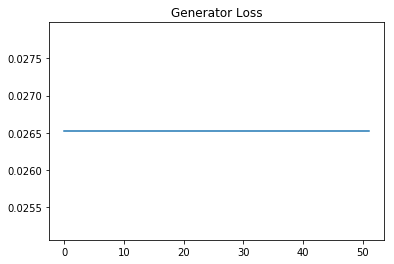

In [653]:
plt.plot(history['loss_g'])
plt.title("Generator Loss")
plt.show()

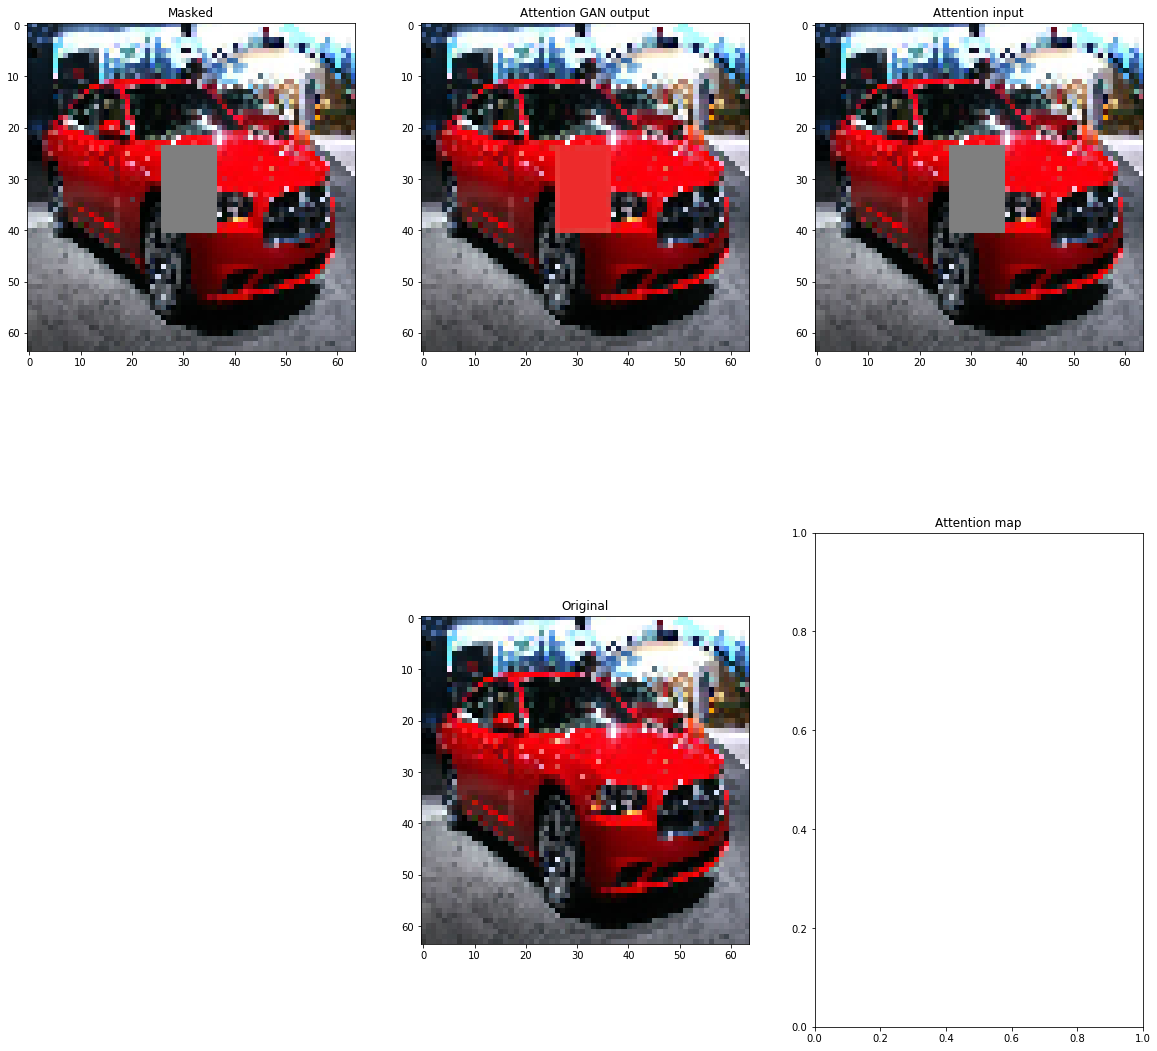

In [466]:
feed_dict = {attention_input: X_test_mask,
             masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

att_inp, out_imgs, = sess_gan.run([attention_input, output_images], 
                                             feed_dict=feed_dict)

i = 61
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(att_inp[i])
plt.title("Attention input")
#plt.subplot(2, 3, 4)
#plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
#plt.title("Masked filled")
plt.subplot(2, 3, 2)
plt.imshow(min_max_norm(out_imgs[i]))
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
#plt.imshow(att_map[i][8].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_test[i])
plt.title("Original")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


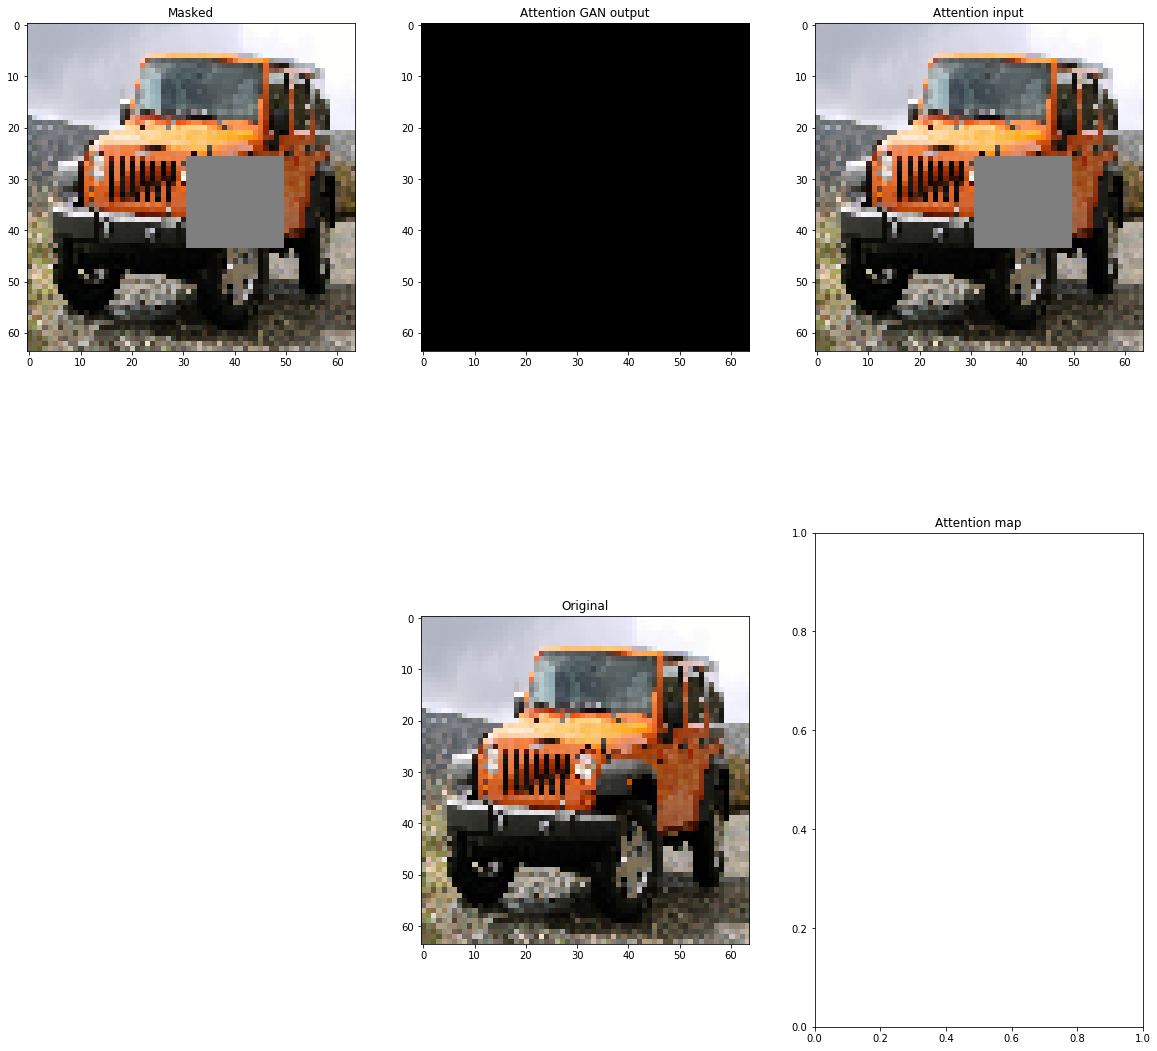

In [677]:
# /!\ TRAIN SET /!\

feed_dict = {attention_input: X_train_mask,
             masked_image_inputs: X_train_mask,
             mask_filter_inputs: X_train_filter,
             real_image_targets: X_train}

att_inp, out_imgs, d1_ = sess_gan.run([attention_input, output_images, d1], 
                                             feed_dict=feed_dict)
i = 0
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_train_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(att_inp[i])
plt.title("Attention input")
#plt.subplot(2, 3, 4)
#plt.imshow(X_train_filter[i]*reco_imgs[i] + (1-X_train_filter[i])*X_train_mask[i])
#plt.title("Masked filled")
plt.subplot(2, 3, 2)
#plt.imshow(out_imgs[i])
plt.imshow(min_max_norm(out_imgs[i]))
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
#plt.imshow(att_map[i][8].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_train[i])
plt.title("Original")

plt.show()

In [580]:
(((X_train[0] - out_imgs)*X_train_filter[0])**2 / 2).sum() / X_train_filter.sum()

0.026154253540704466

In [194]:
def min_max_norm(image):
    max_ = image.max()
    min_ = image.min()
    return (image - min_) / (max_ - min_) 

In [678]:
out_imgs.max()

0.0

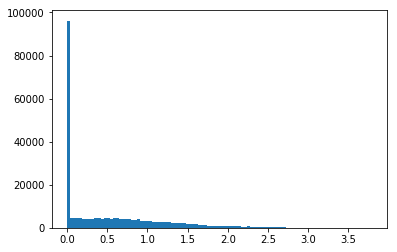

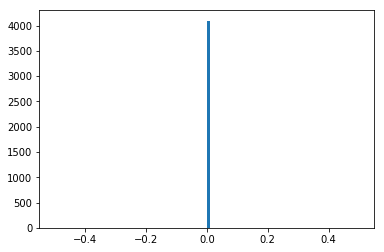

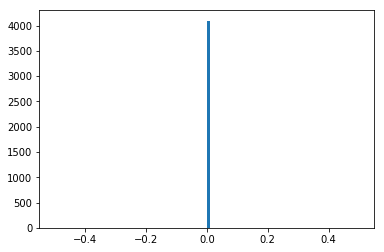

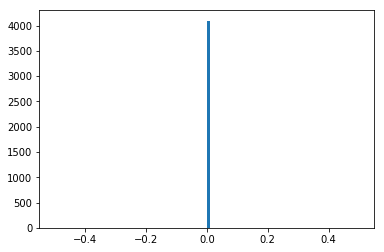

In [679]:
#plt.imshow(d0_[10])
plt.hist(d1_.flatten(), bins=100)
plt.show()
plt.hist(out_imgs[i][:,:,0].flatten(), bins=100)
plt.show()
plt.hist(out_imgs[i][:,:,1].flatten(), bins=100)
plt.show()
plt.hist(out_imgs[i][:,:,2].flatten(), bins=100)
plt.show()

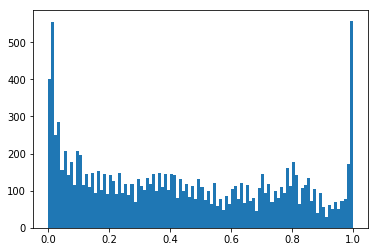

In [680]:
plt.hist(X_train[i].flatten(), bins=100)
plt.show()

# No-GAN Model

In [8]:
image_size = (64, 64, 3)
n_pixels = int(image_size[0]*image_size[1]*image_size[2])

epochs = 25
batch_size = 64

In [9]:
tf.reset_default_graph()

with tf.variable_scope("approx_net"):
    # user inputs
    masked_image_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    mask_filter_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    real_image_targets = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    # reshaping as a long vector (for Dense Net ...)
    masked_image_inputs_r = tf.reshape(masked_image_inputs, shape=(-1,n_pixels))
    
    # First reconstruction net to grossly approximate the masked region
    images = tf.layers.dense(masked_image_inputs_r, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=100) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    reconstructed_images = tf.layers.dense(images, units=n_pixels, activation=tf.nn.sigmoid)
    
    # reshaping as a image format again (for Dense Net ...)
    reconstructed_images = tf.reshape(reconstructed_images, shape=(-1,)+image_size)
    
    
with tf.variable_scope("attention_generator"):
    
    attention_input = tf.multiply(mask_filter_inputs, reconstructed_images) \
                    + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
    #attention_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    attention_input = tf.layers.conv2d(attention_input, filters=18, kernel_size=3, strides=2, padding="same")
    attention_input = tf.layers.conv2d(attention_input, filters=18, kernel_size=3, strides=2, padding="same")
    
    f_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    g_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    
    h_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    attention_map = tf.expand_dims(tf.nn.softmax(tf.reduce_sum(tf.multiply(f_branch, g_branch), axis=3)), 3)
    #, transpose_a=True)#tf.nn.softmax(tf.matmul(f_branch, g_branch, transpose_a=False))
    
    attention_output = tf.multiply(attention_map, h_branch)
    output_images = tf.layers.conv2d_transpose(attention_output, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    output_images = tf.layers.conv2d_transpose(output_images, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    

"""with tf.variable_scope("discriminator"):
    
    discriminator_input = tf.multiply(mask_filter_inputs, output_images) \
                        + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
        
    x = tf.layers.conv2d(discriminator_input, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=256, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    reshape = tf.reshape(x, [batch_size, -1])
    classify = tf.layers.dense(reshape, 2, activation=tf.nn.sigmoid)"""
    
    
with tf.variable_scope('losses'):
    # Loss is L2 error on the masked region only
    #loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.))
    #reco_loss1 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - reconstructed_images)*mask_filter_inputs))
    reco_loss1 = tf.losses.absolute_difference(real_image_targets*mask_filter_inputs,reconstructed_images*mask_filter_inputs)
    #reco_loss2 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - output_images)*mask_filter_inputs)) + reco_loss1
    
    reco_loss2 = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.)) \
                 -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, output_images, max_val=1.))
    
with tf.variable_scope('Optimizer'):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # To train the approx net only
    vars_approx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "approx_net")
    train_op_approx = optimizer.minimize(reco_loss1, var_list=vars_approx)
    # To train the attention only
    vars_attention = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "attention_generator")
    train_op_attention = optimizer.minimize(reco_loss2)#, var_list=vars_attention)
    

In [10]:
# /!\/!\/!\/!\/!\
sess = tf.Session()
    
sess.run(tf.global_variables_initializer())
# /!\/!\/!\/!\/!\

In [11]:
for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        # Draw a random batch and train on it
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        feed_dict = {masked_image_inputs: X_train_mask[idx],
                     mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx]}
        #_, train_loss = sess.run([train_op_approx, reco_loss1], feed_dict=feed_dict)
        _, train_loss = sess.run([train_op_attention, reco_loss2], feed_dict=feed_dict)
    if epoch % 1 == 0:
        feed_dict = {masked_image_inputs: X_test_mask,
                     mask_filter_inputs: X_test_filter,
                     real_image_targets: X_test}
        test_loss = sess.run(reco_loss2, feed_dict=feed_dict)
        print("Step {0}/{1} \ttrain loss: {2} \ttest loss {3}".format(epoch, epochs, train_loss, test_loss))
        #if epoch % 10 == 0:
        #    reco_imgs = sess.run(reconstructed_images, feed_dict=feed_dict)
        #    i = 3
        #    plt.imshow(X_test_mask[i])
        #    plt.show()
        #    plt.imshow(reco_imgs[i])
        #    plt.show()
        #    plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
        #    plt.show()
        #    plt.imshow(X_test[i])
        #   plt.show()

Step 0/25 	train loss: -0.17712527513504028 	test loss -0.21786195039749146


KeyboardInterrupt: 

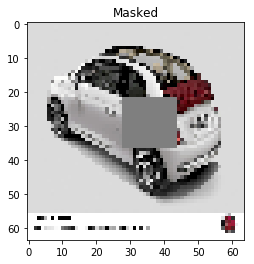

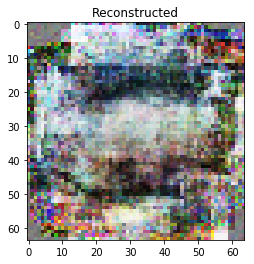

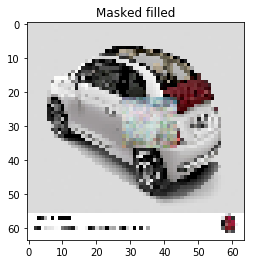

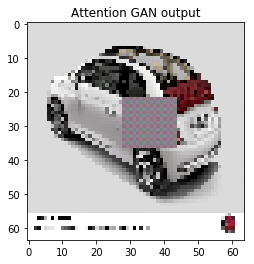

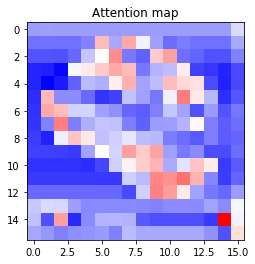

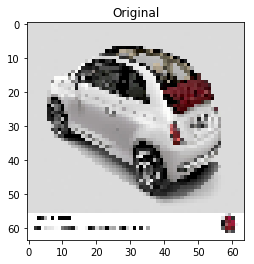

In [149]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, out_imgs = sess.run([reconstructed_images, attention_map, output_images], 
                                        feed_dict=feed_dict)

i = 99
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.show()
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.show()
plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Masked filled")
plt.show()
plt.imshow(X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Attention GAN output")
plt.show()
plt.imshow(att_map[i].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.show()
plt.imshow(X_test[i])
plt.title("Original")
plt.show()

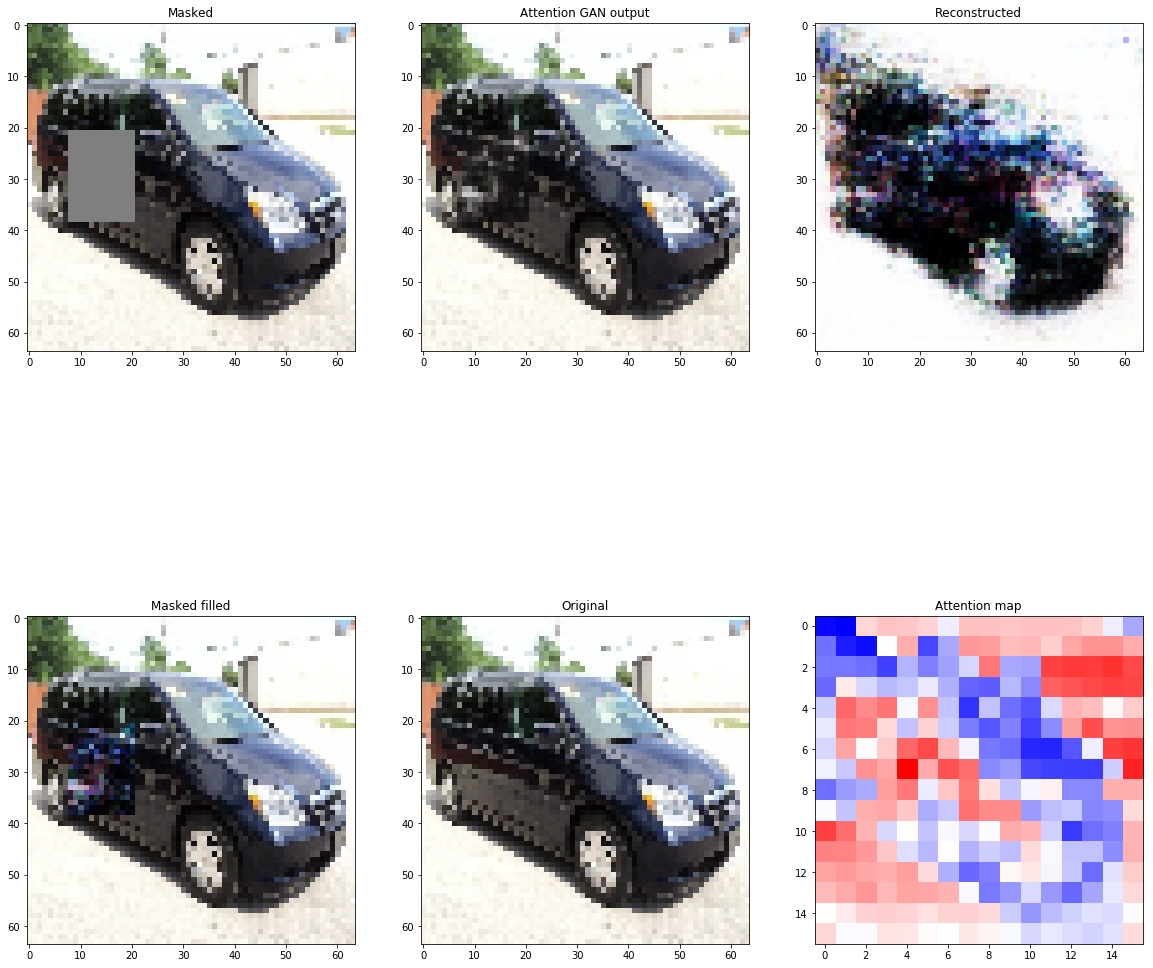

In [348]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, out_imgs = sess.run([reconstructed_images, attention_map, output_images], 
                                        feed_dict=feed_dict)

i = 5
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.subplot(2, 3, 4)
plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Masked filled")
plt.subplot(2, 3, 2)
plt.imshow(X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_test[i])
plt.title("Original")

plt.show()

In [178]:
feed_dict2 = {attention_input: reconstructed_images}

sess.run(output_images, feed_dict=feed_dict2)

TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, numpy ndarrays, or TensorHandles.For reference, the tensor object was Tensor("approx_net/Reshape_1:0", shape=(?, 64, 64, 3), dtype=float32) which was passed to the feed with key Tensor("attention_generator/add:0", shape=(?, 64, 64, 3), dtype=float32).

# Sandbox Zone

In [78]:
#img1 = tf.Variable(X_train[0].transpose(1, 2, 0))
#img2 = tf.Variable(X_train[0].transpose(1, 2, 0))
img1 = tf.placeholder(tf.float32, shape=(64, 64, 3))
img2 = tf.placeholder(tf.float32, shape=(64, 64, 3))
max_val = 1.

-0.90643877


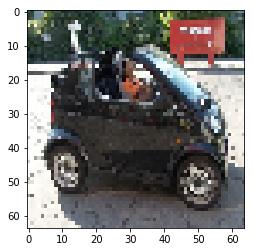

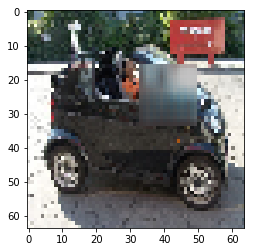

In [80]:
similarity = tf.image.ssim(img1, img2, max_val=1.)

with tf.Session() as sess:
    #print(sess.run(similarity, feed_dict={img1:X_train[0], img2:X_train_mask[0]}))
    print(sess.run(-similarity, feed_dict={img1:X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i], 
                                          img2:X_test[i]}))

plt.imshow(X_test[i])
plt.show()
plt.imshow(X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.show()

In [117]:
with tf.Session() as sess:
    z = tf.image.extract_image_patches(tf.expand_dims(img1, 0), 
                                       [1, 8, 8, 1], 
                                       [1, 8, 8, 1], 
                                       [1,1,1,1], 
                                       padding="SAME", 
                                       name=None)
    print(z.shape)

(1, 8, 8, 192)


In [569]:
true_labels2_test = np.array([[1., 1., 0., 0.]])
class_logits2_test = np.array([[60., 60., 14., 14.]])
sess_test = tf.Session()
sess_test.run(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels2_test, logits=class_logits2_test, name="test"))

array([1.38629436])

In [683]:
true_labels2_test = np.array([[
                               [0.1, 0.5, 0.5],
                               [0., 0., 0.5],
                               [0., 0.5, 1]
                              ]
                             ])
class_logits2_test = np.array([[
                               [0., 1., 0.5],
                               [0., 0., 0.5],
                               [0., 0.45, 0.95]
                              ]
                             ])
sess_test = tf.Session()
sess_test.run(tf.nn.l2_loss(true_labels2_test - class_logits2_test))

0.1325

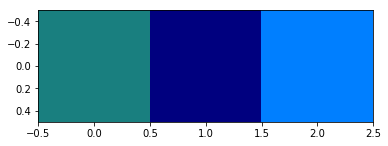

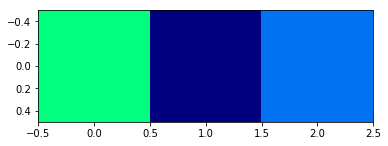

In [684]:
plt.imshow(true_labels2_test)
plt.show()
plt.imshow(class_logits2_test)
plt.show()

In [33]:
# --------------- DISCRIMINATOR 2 ----------------- # 

with tf.variable_scope("discriminator2"):
    
    # Labels fake/real
    true_labels2 = tf.placeholder(tf.float32, shape=[None,2])
    discriminator_input2 = tf.placeholder(tf.float32, shape=(None,)+image_size)
        
    x2 = tf.layers.conv2d(discriminator_input2, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.conv2d(x2, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.conv2d(x2, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.conv2d(x2, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.flatten(x2)
    x2 = tf.layers.dense(x2, units=50, activation=tf.nn.relu)
    #class_logits = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
    class_logits2 = tf.layers.dense(x2, units=2)
    #class_logits2 = tf.squeeze(class_logits2, axis=1)
    
    # Loss function
    d_loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels2, 
                                                                     logits=class_logits2,
                                                                     name="d_loss2"))
    
    # Optimizer
    optimizer_d2 = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # Op
    train_op_d2 = optimizer_d2.minimize(d_loss2)

In [36]:
epochs = 20
batch_size = 64

for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        # load batch_size fake images
        #idx = np.random.randint(0, X_train.shape[0], batch_size)
        #fake_images_mask = X_train_mask[idx]
        #fake_images_filter = X_train_filter[idx]
        #feed_dict = {masked_image_inputs: fake_images_mask,
        #             mask_filter_inputs: fake_images_filter}
        #fake_images = sess_gan.run(discriminator_input, feed_dict=feed_dict)
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        fake_images = X_train_mask[idx] # take masked images
        
        # load batch_size real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        #labels = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input2: input_images,
                     true_labels2: labels}
        _, train_loss_d2 = sess_gan.run([train_op_d2, d_loss2], feed_dict=feed_dict)
        
        #print(sess_gan.run(class_logits2, feed_dict=feed_dict))
        
    if epoch % 1 == 0:
        print("Step {0}/{1} \ttrain D loss: {2}"\
              .format(epoch, epochs, train_loss_d2))

Step 0/20 	train D loss: 0.6845999956130981
Step 1/20 	train D loss: 0.6838455200195312
Step 2/20 	train D loss: 0.6503829956054688
Step 3/20 	train D loss: 0.6403860449790955
Step 4/20 	train D loss: 0.4531041979789734
Step 5/20 	train D loss: 0.4385523200035095
Step 6/20 	train D loss: 0.4121772348880768
Step 7/20 	train D loss: 0.571540117263794
Step 8/20 	train D loss: 0.4536709785461426
Step 9/20 	train D loss: 0.6792052984237671
Step 10/20 	train D loss: 0.5261644721031189
Step 11/20 	train D loss: 0.5062122344970703
Step 12/20 	train D loss: 0.7310159206390381
Step 13/20 	train D loss: 0.6812150478363037
Step 14/20 	train D loss: 0.6814185380935669
Step 15/20 	train D loss: 0.5487008690834045
Step 16/20 	train D loss: 0.5157099962234497
Step 17/20 	train D loss: 0.46325716376304626
Step 18/20 	train D loss: 0.5435051918029785
Step 19/20 	train D loss: 0.4738573431968689
